## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

In [40]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

#parameter
nx = 9 #number of corners in x
ny = 6 #number of corners in y
idx = 3 #image index
offset = 100 #offset for unwarped image

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

fnames = []
objpoints_list = []
imgpoints_list = []
img_list = []
img_cal_list = []

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        fnames.append(fname)
        img_list.append(img)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        img_cal_list.append(img)
        objpoints_list.append(objpoints)
        imgpoints_list.append(imgpoints)


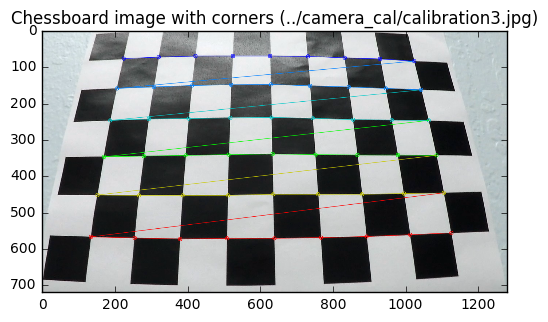

In [41]:
plt.imshow(img_list[idx])
plt.title("Chessboard image with corners ("+fnames[idx]+")")
plt.show()

## Distortion correction

In [43]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dist_coef = (mtx, dist, None, mtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist,mtx

undist_list = []
mtx_list = []

for i in range(len(img_list)):
    undist,mtx = cal_undistort(img_list[i],objpoints_list[i],imgpoints_list[i])
    undist_list.append(undist)
    mtx_list.append(mtx)


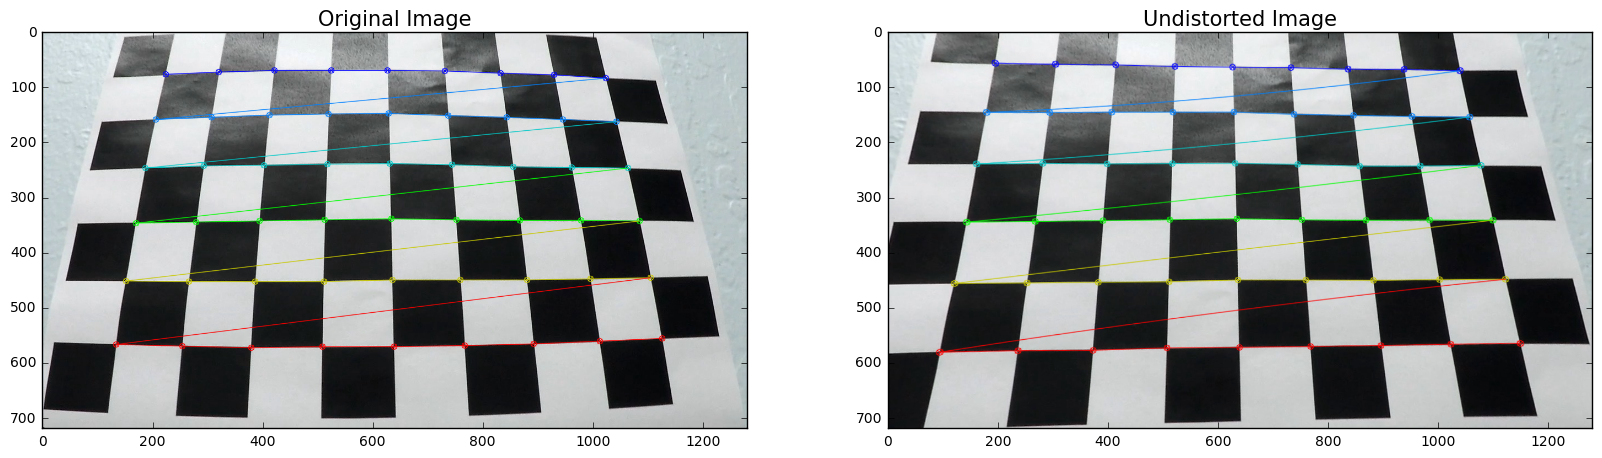

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_list[idx])
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undist_list[idx])
ax2.set_title('Undistorted Image', fontsize=15)

## Perspective Transformation

In [46]:
def corners_unwarp(img, nx, ny, mtx, undist, offset):
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if(ret==True):
       cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
       img_size = (gray.shape[1], gray.shape[0])
       src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
       dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
    else:
        return None, None
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

topdown_list= []

for i in range(len(img_list)):
    top_down, perspective_M = corners_unwarp(img_list[i], nx, ny,  mtx_list[i], undist_list[i], offset)
    if(top_down is None): continue
    topdown_list.append(top_down)

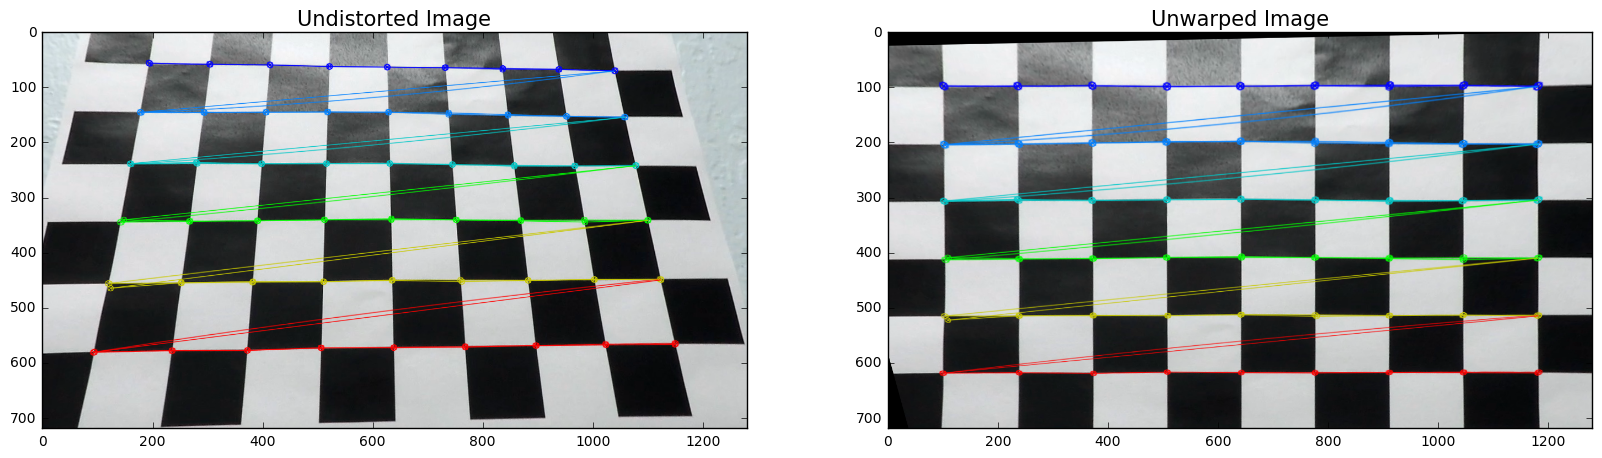

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist_list[idx])
ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(topdown_list[0])
ax2.set_title('Unwarped Image', fontsize=15)